# Double Pendulum Analysis: Hamiltonian Neural Networks vs Baseline Model

This notebook provides a comprehensive analysis of the double pendulum system using Hamiltonian Neural Networks (HNN) and a baseline model. We'll cover:

1. Introduction to the double pendulum system
2. Hamilton's equations for the double pendulum
3. Loading and preprocessing the dataset
4. Importing trained models (HNN and baseline)
5. Performance comparison and analysis
6. Visualization of results
7. Chaotic behavior analysis
8. Conclusion and discussion

Let's start by importing the necessary libraries and setting up our environment.

In [1]:
import os
os.chdir('/workspaces/Hamiltonian-Neural-Networks-Pendulums')

import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from src.models.hnn import HNN
from src.double_pendulum.config import double_pendulum_config as config
from src.double_pendulum.config import double_pendulum_training as train_config

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

## 1. Introduction to the Double Pendulum System

A double pendulum consists of two pendulums attached end to end. It's a classic example of a simple chaotic system, exhibiting complex behavior that is highly sensitive to initial conditions.

The state of the double pendulum is described by four variables:
- $\theta_1$, $\theta_2$: The angles of the first and second pendulum from the vertical
- p1, p2: The angular momenta of the first and second pendulum

The system is governed by parameters:
- m1, m2: Masses of the pendulum bobs
- l1, l2: Lengths of the pendulums
- g: Acceleration due to gravity

## 2. Hamilton's Equations for the Double Pendulum

The Hamiltonian for a double pendulum is:

$$H = T + V = \frac{m_2l_2^2p_{\theta_1}^2 + (m_1 + m_2)l_1^2p_{\theta_2}^2 - 2m_2l_1l_2p_{\theta_1}p_{\theta_2}cos(\theta_1-\theta_2)}{2m_2l_1^2l_2^2[m_1+m_2sin^2(\theta_1 - \theta_2)]} - (m_1 + m_2)gl_1cos(\theta_1)-m_2gl_2cos(\theta_2)$$

Where $T$ (kinetic energy) and $V$ (potential energy) are complex functions of the state variables and parameters.

Hamilton's equations for this system are:

1. $\frac{dθ1}{dt} = \frac{∂H}{∂p_1}$
2. $\frac{dθ2}{dt} = \frac{∂H}{∂p_2}$
3. $\frac{dp1}{dt} = -\frac{∂H}{∂θ_1}$
4. $\frac{dp2}{dt} = -\frac{∂H}{∂θ_2}$

These equations describe the time evolution of the double pendulum's state $\left(\theta_1, \theta_2, p_1, p_2\right)$.

## 3. Loading and Preprocessing the Dataset

Let's load our dataset and prepare it for analysis.

In [2]:
# Load the dataset
data_path = "data/double_pendulum/double_pendulum_dataset_stormer_verlet.pt"
data = torch.load(data_path)

# Extract states (theta1, theta2, p1, p2) from the dataset
states = data[:, :, :4].reshape(-1, 4)

print(f"Dataset shape: {data.shape}")
print(f"Number of trajectories: {data.shape[0]}")
print(f"Trajectory length: {data.shape[1]}")
print(f"Total number of states: {states.shape[0]}")

Dataset shape: torch.Size([900, 61, 16])
Number of trajectories: 900
Trajectory length: 61
Total number of states: 54900


/tmp/ipykernel_3284/1945618942.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data = torch.load(data_path)


Let's visualize the distribution of states in various 2D projections of the phase space.

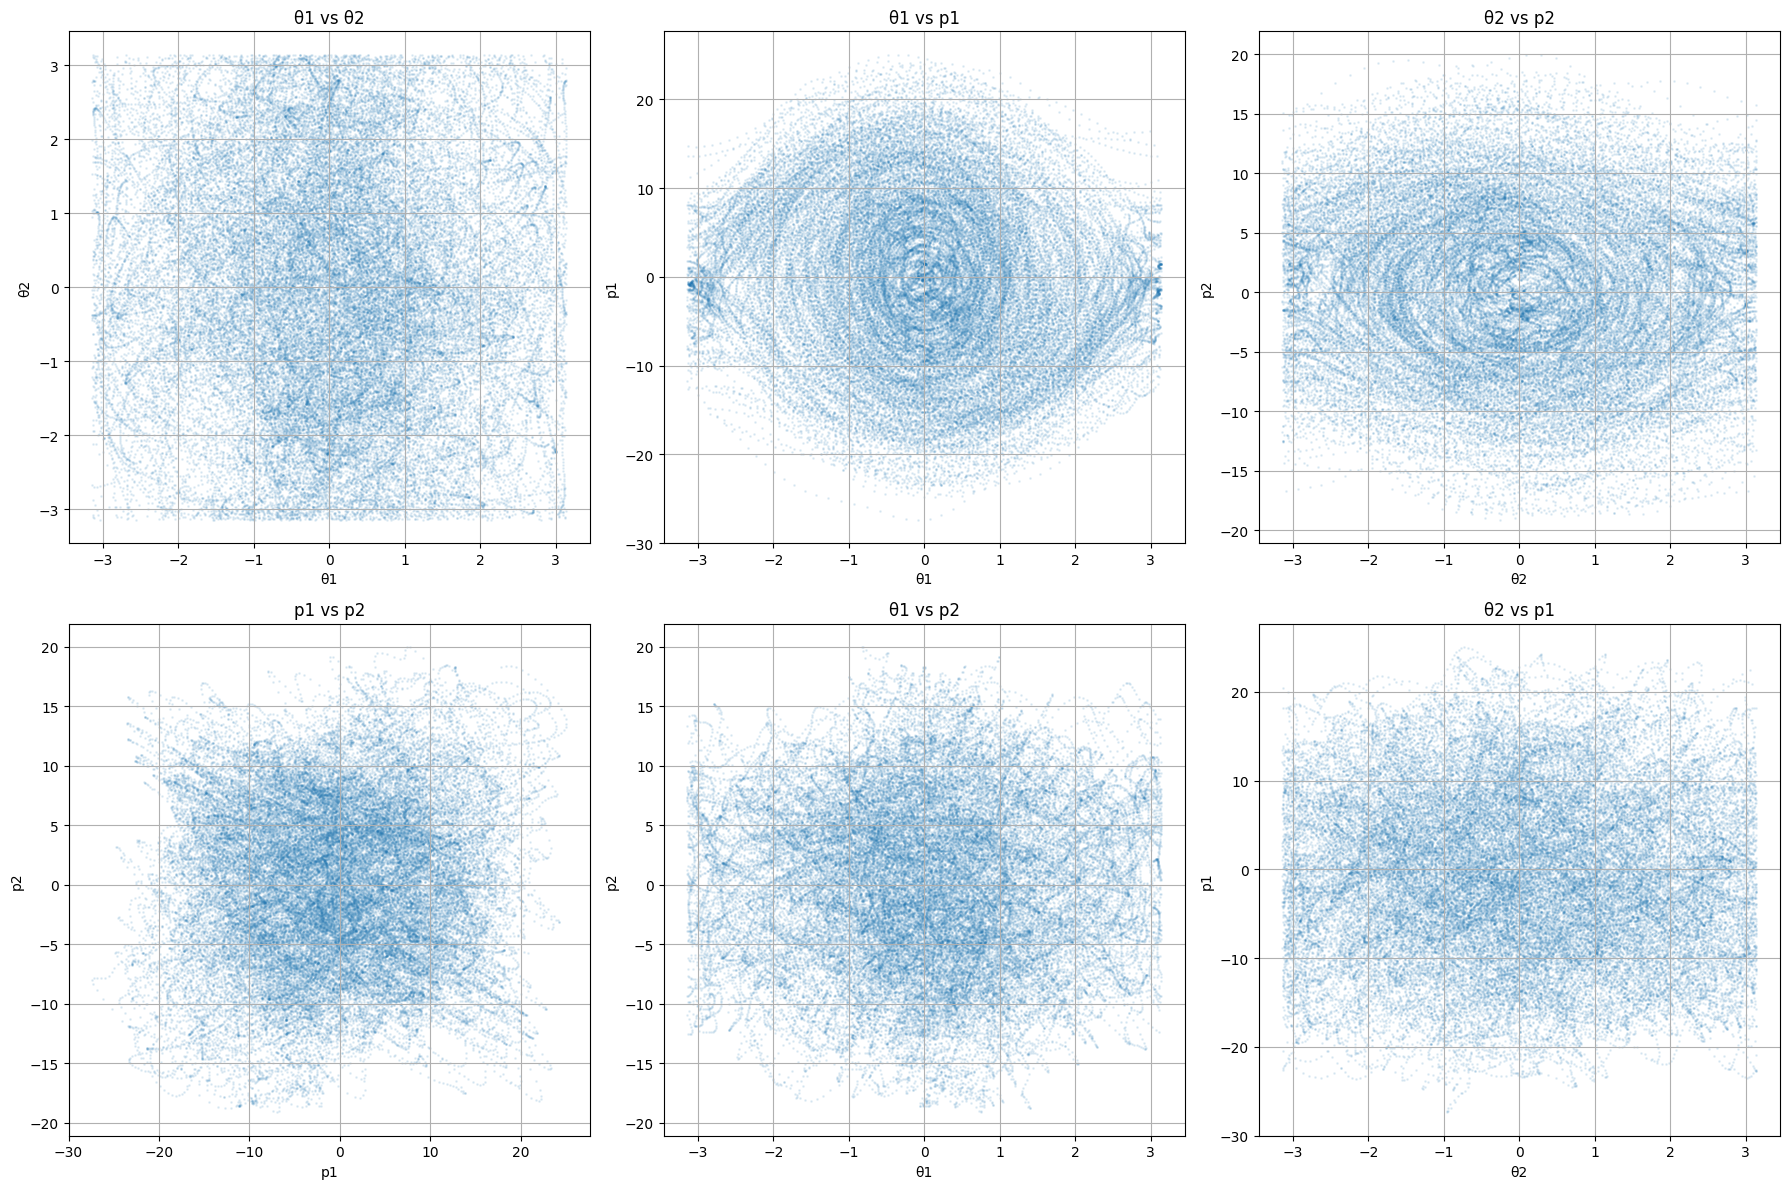

In [3]:
fig, axs = plt.subplots(2, 3, figsize=(18, 12))
axs = axs.ravel()

combinations = [(0, 1, 'θ1', 'θ2'), (0, 2, 'θ1', 'p1'), (1, 3, 'θ2', 'p2'),
                (2, 3, 'p1', 'p2'), (0, 3, 'θ1', 'p2'), (1, 2, 'θ2', 'p1')]

for i, (idx1, idx2, label1, label2) in enumerate(combinations):
    axs[i].scatter(states[:, idx1], states[:, idx2], alpha=0.1, s=1)
    axs[i].set_xlabel(label1)
    axs[i].set_ylabel(label2)
    axs[i].set_title(f'{label1} vs {label2}')
    axs[i].grid(True)

plt.tight_layout()
plt.show()

## 4. Importing Trained Models

Now, let's import our trained HNN and baseline models (800 training epochs for both).

In [4]:
def load_model(model_path: str, n_elements: int, baseline: bool) -> nn.Module:
    model = HNN(n_elements, hidden_dims=train_config['hidden_dim'], 
                num_layers=train_config['num_layers'], baseline=baseline)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

hnn_model = load_model("results/double_pendulum/models/model_hnn.pth", n_elements=2, baseline=False)
baseline_model = load_model("results/double_pendulum/models/model_baseline.pth", n_elements=2, baseline=True)

print("Models loaded successfully.")

Models loaded successfully.


/tmp/ipykernel_3284/746262270.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


## 5. Performance Comparison and Analysis

Let's compare the performance of our HNN and baseline models by computing the RMSE in the phase space.

In [5]:
def compute_rmse(model: nn.Module, states: torch.Tensor, dt: float) -> np.ndarray:
    with torch.no_grad():
        pred_derivatives = model(states)
        true_next_states = states[1:]
        pred_next_states = states[:-1] + pred_derivatives[:-1] * dt
        rmse = torch.sqrt(torch.mean((true_next_states - pred_next_states)**2, dim=1))
    return rmse.numpy()

hnn_rmse = compute_rmse(hnn_model, states.clone().detach(), config['dt'])
baseline_rmse = compute_rmse(baseline_model, states.clone().detach(), config['dt'])

print(f"Average RMSE - HNN: {hnn_rmse.mean():.6f}, Baseline: {baseline_rmse.mean():.6f}")

Average RMSE - HNN: 0.145258, Baseline: 0.145319


## 6. Visualization of Results

Let's visualize the RMSE in different projections of the phase space for both models.

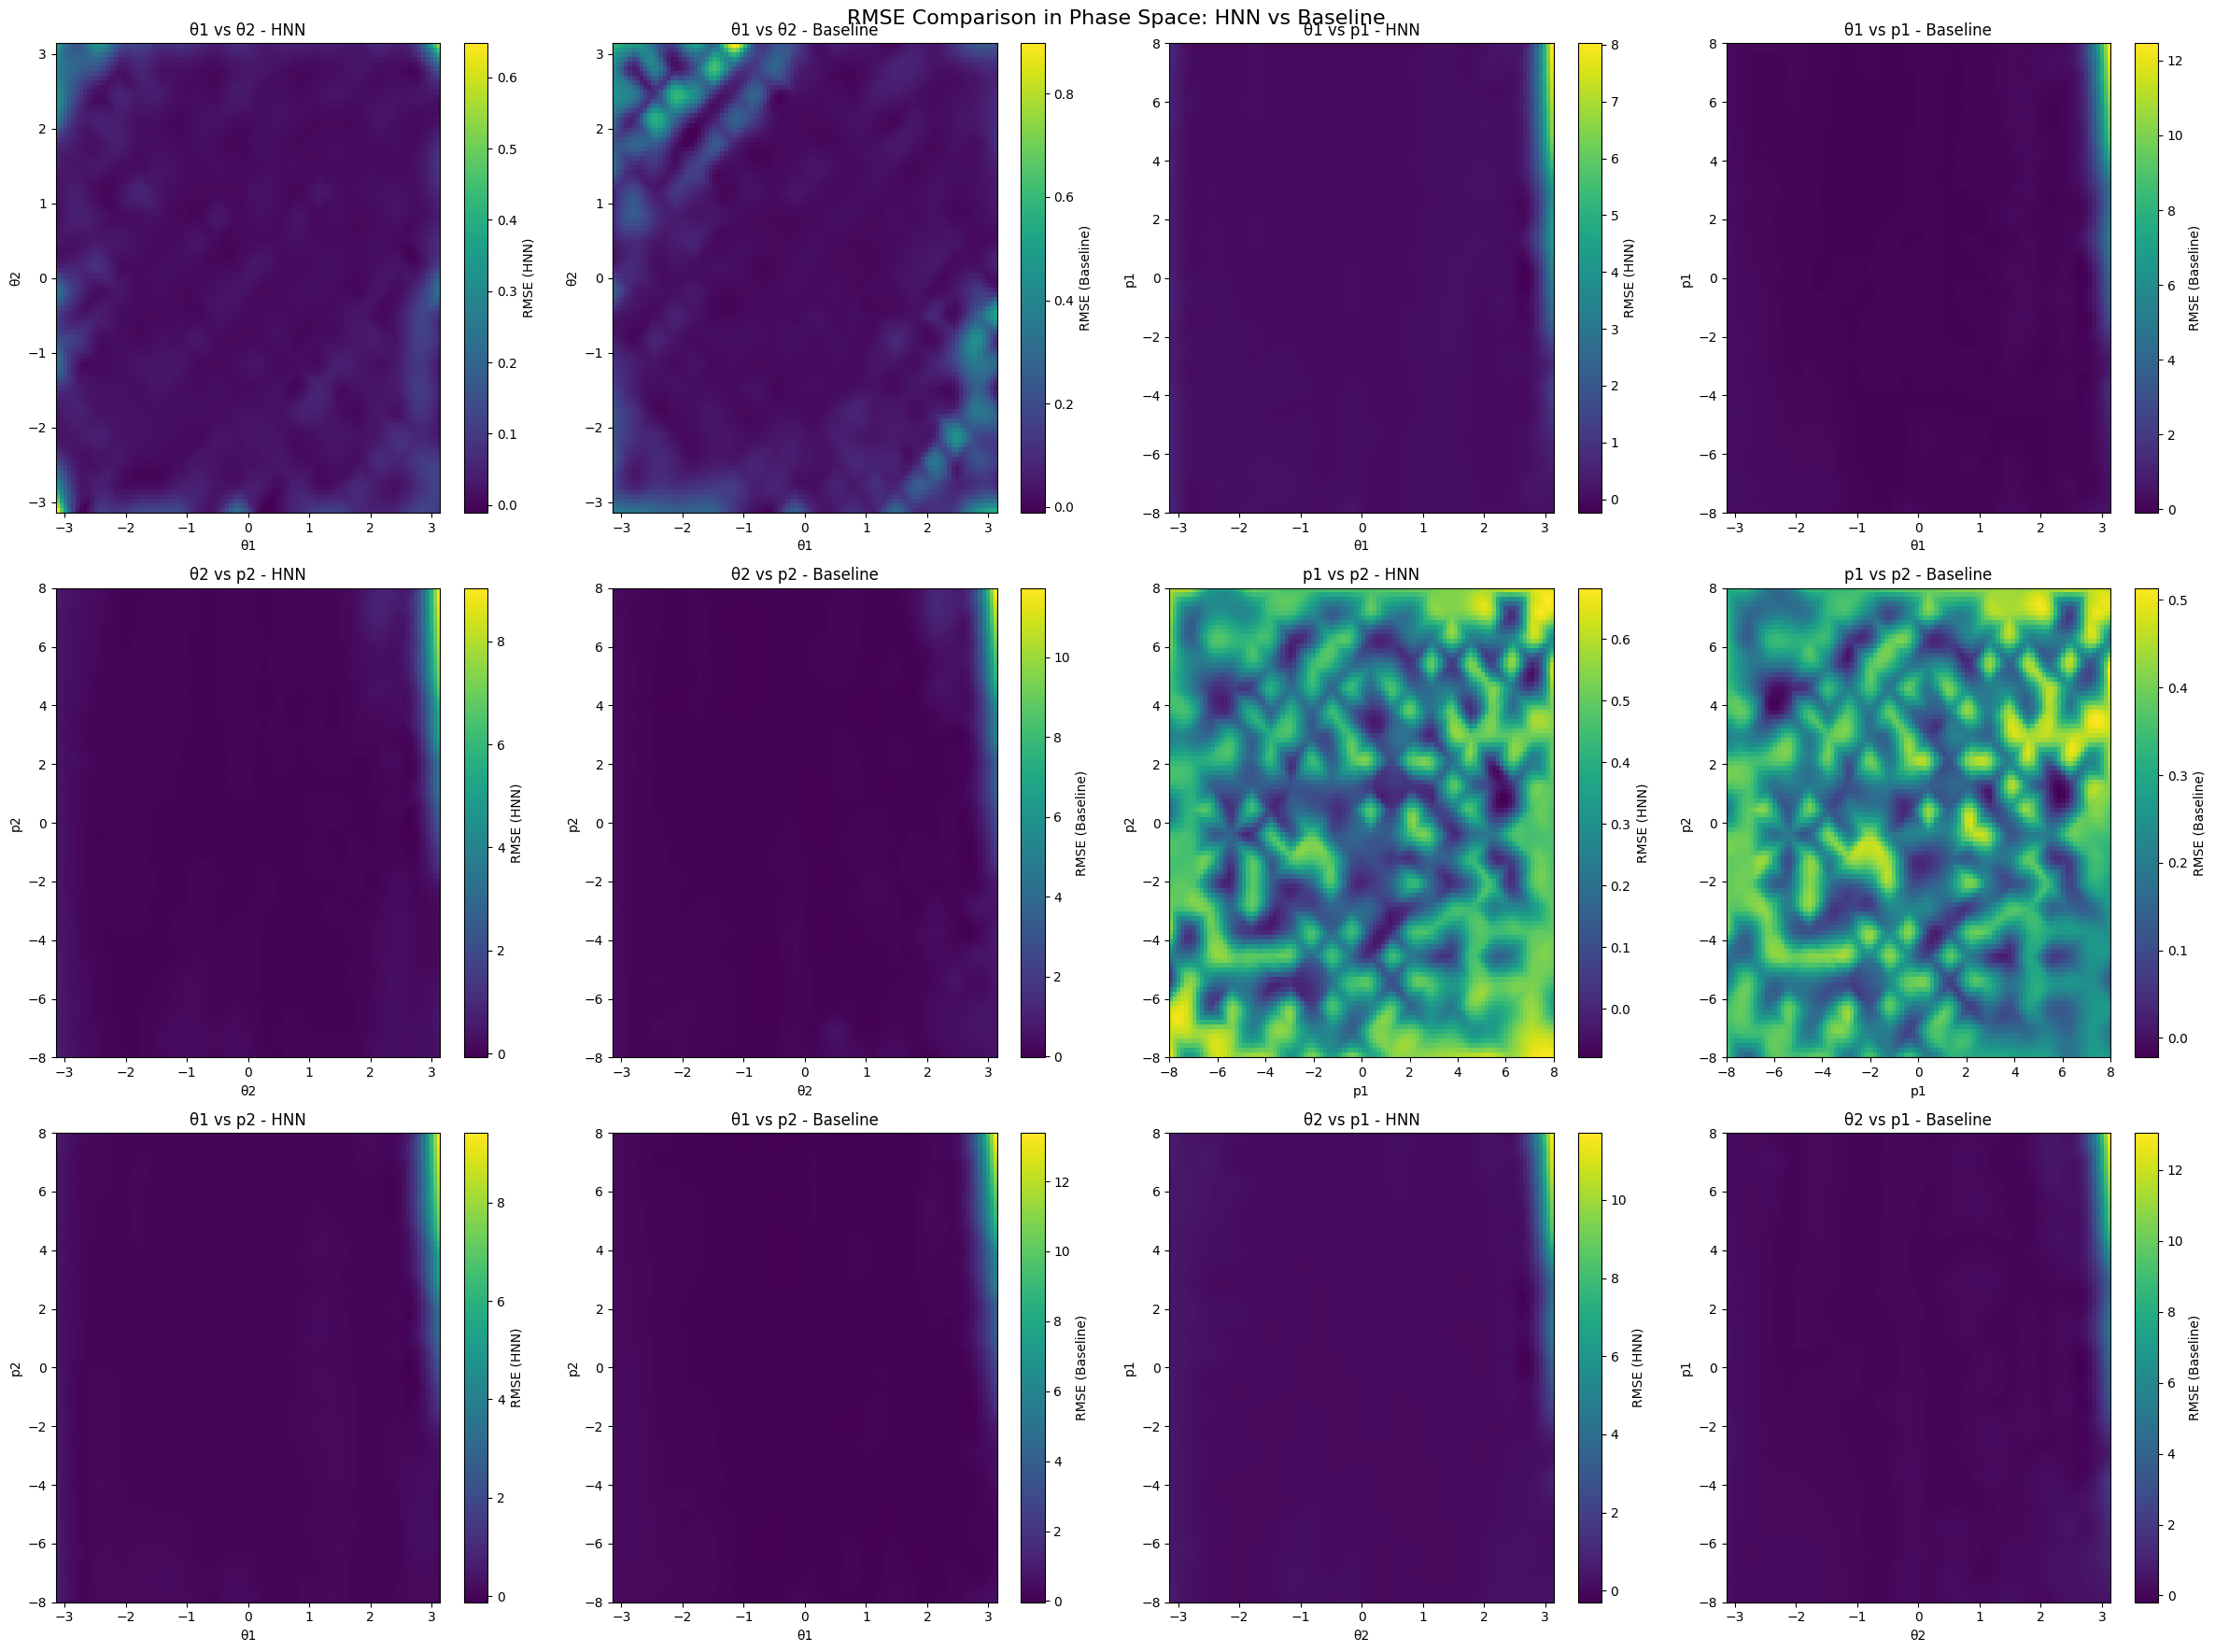

In [6]:
from scipy.interpolate import griddata
from src.common.utils.integrators import double_pendulum_position_derivative, double_pendulum_momentum_derivative

def true_dynamics_double_pendulum(state, m1, m2, l1, l2, g):
    dtheta1_dt, dtheta2_dt = double_pendulum_position_derivative(state, m1, m2, l1, l2, g)
    dp1_dt, dp2_dt = double_pendulum_momentum_derivative(state, m1, m2, l1, l2, g)

    return np.stack([dtheta1_dt, dtheta2_dt, dp1_dt, dp2_dt])

def compute_rmse_phase_space_double_pendulum(model, domain_range=(-np.pi, np.pi, -8, 8), resolution=20, m1=2.0, m2=1.0, l1=1.5, l2=2.0, g=3.0):
    theta_min, theta_max, p_min, p_max = domain_range

    theta1 = np.linspace(theta_min, theta_max, resolution)
    theta2 = np.linspace(theta_min, theta_max, resolution)
    p1 = np.linspace(p_min, p_max, resolution)
    p2 = np.linspace(p_min, p_max, resolution)

    grid = np.meshgrid(theta1, theta2, p1, p2, indexing='ij')
    states = np.stack(grid).reshape(4, -1).T
    
    true_dyn = true_dynamics_double_pendulum(states.T, m1, m2, l1, l2, g).T
   
    model.eval()
    with torch.no_grad():
        states_torch = torch.tensor(states, dtype=torch.float32)
        model_dyn = model(states_torch).numpy()

    mse = np.mean((true_dyn - model_dyn)**2, axis=1)
    rmse = np.sqrt(mse)

    return states, rmse

def plot_rmse_phase_space_comparison_double_pendulum(states, rmse_hnn, rmse_baseline, domain_range=(-np.pi, np.pi, -8, 8), resolution=100):
    _, axs = plt.subplots(3, 4, figsize=(24, 18))
    plt.subplots_adjust(wspace=0.4, hspace=0.3)
    
    combinations = [(0, 1, 'θ1', 'θ2'), (0, 2, 'θ1', 'p1'), (1, 3, 'θ2', 'p2'),
                    (2, 3, 'p1', 'p2'), (0, 3, 'θ1', 'p2'), (1, 2, 'θ2', 'p1')]
    
    for i, (idx1, idx2, label1, label2) in enumerate(combinations):
        # Create a fine grid for interpolation
        x_fine = np.linspace(states[:, idx1].min(), states[:, idx1].max(), resolution)
        y_fine = np.linspace(states[:, idx2].min(), states[:, idx2].max(), resolution)
        x_grid, y_grid = np.meshgrid(x_fine, y_fine)
        
        # Interpolate RMSE values onto the fine grid
        rmse_hnn_interp = griddata(states[:, [idx1, idx2]], rmse_hnn, (x_grid, y_grid), method='cubic')
        rmse_baseline_interp = griddata(states[:, [idx1, idx2]], rmse_baseline, (x_grid, y_grid), method='cubic')
        
        # Plot HNN
        im1 = axs[i//2, 2*i%4].imshow(rmse_hnn_interp, extent=[x_fine.min(), x_fine.max(), y_fine.min(), y_fine.max()], 
                                      origin='lower', aspect='auto', cmap='viridis')
        axs[i//2, 2*i%4].set_title(f'{label1} vs {label2} - HNN', fontsize=12)
        axs[i//2, 2*i%4].set_xlabel(label1, fontsize=10)
        axs[i//2, 2*i%4].set_ylabel(label2, fontsize=10)
        plt.colorbar(im1, ax=axs[i//2, 2*i%4], label='RMSE (HNN)')
        
        # Plot Baseline
        im2 = axs[i//2, 2*i%4+1].imshow(rmse_baseline_interp, extent=[x_fine.min(), x_fine.max(), y_fine.min(), y_fine.max()], 
                                        origin='lower', aspect='auto', cmap='viridis')
        axs[i//2, 2*i%4+1].set_title(f'{label1} vs {label2} - Baseline', fontsize=12)
        axs[i//2, 2*i%4+1].set_xlabel(label1, fontsize=10)
        axs[i//2, 2*i%4+1].set_ylabel(label2, fontsize=10)
        plt.colorbar(im2, ax=axs[i//2, 2*i%4+1], label='RMSE (Baseline)')
    
    plt.suptitle('RMSE Comparison in Phase Space: HNN vs Baseline', fontsize=16)
    plt.tight_layout()
    plt.show()

states, rmse_hnn = compute_rmse_phase_space_double_pendulum(hnn_model, domain_range=(-np.pi, np.pi, -8, 8), resolution=20)
_, rmse_baseline = compute_rmse_phase_space_double_pendulum(baseline_model, domain_range=(-np.pi, np.pi, -8, 8), resolution=20)
plot_rmse_phase_space_comparison_double_pendulum(states, rmse_hnn, rmse_baseline)

From these plots it's difficult to distinguish the systems, however there are differences that we will see later

## 7. Chaotic Behavior Analysis

The double pendulum is known for its chaotic behavior. Let's analyze how well our models capture this chaotic nature by comparing trajectories with slightly different initial conditions.

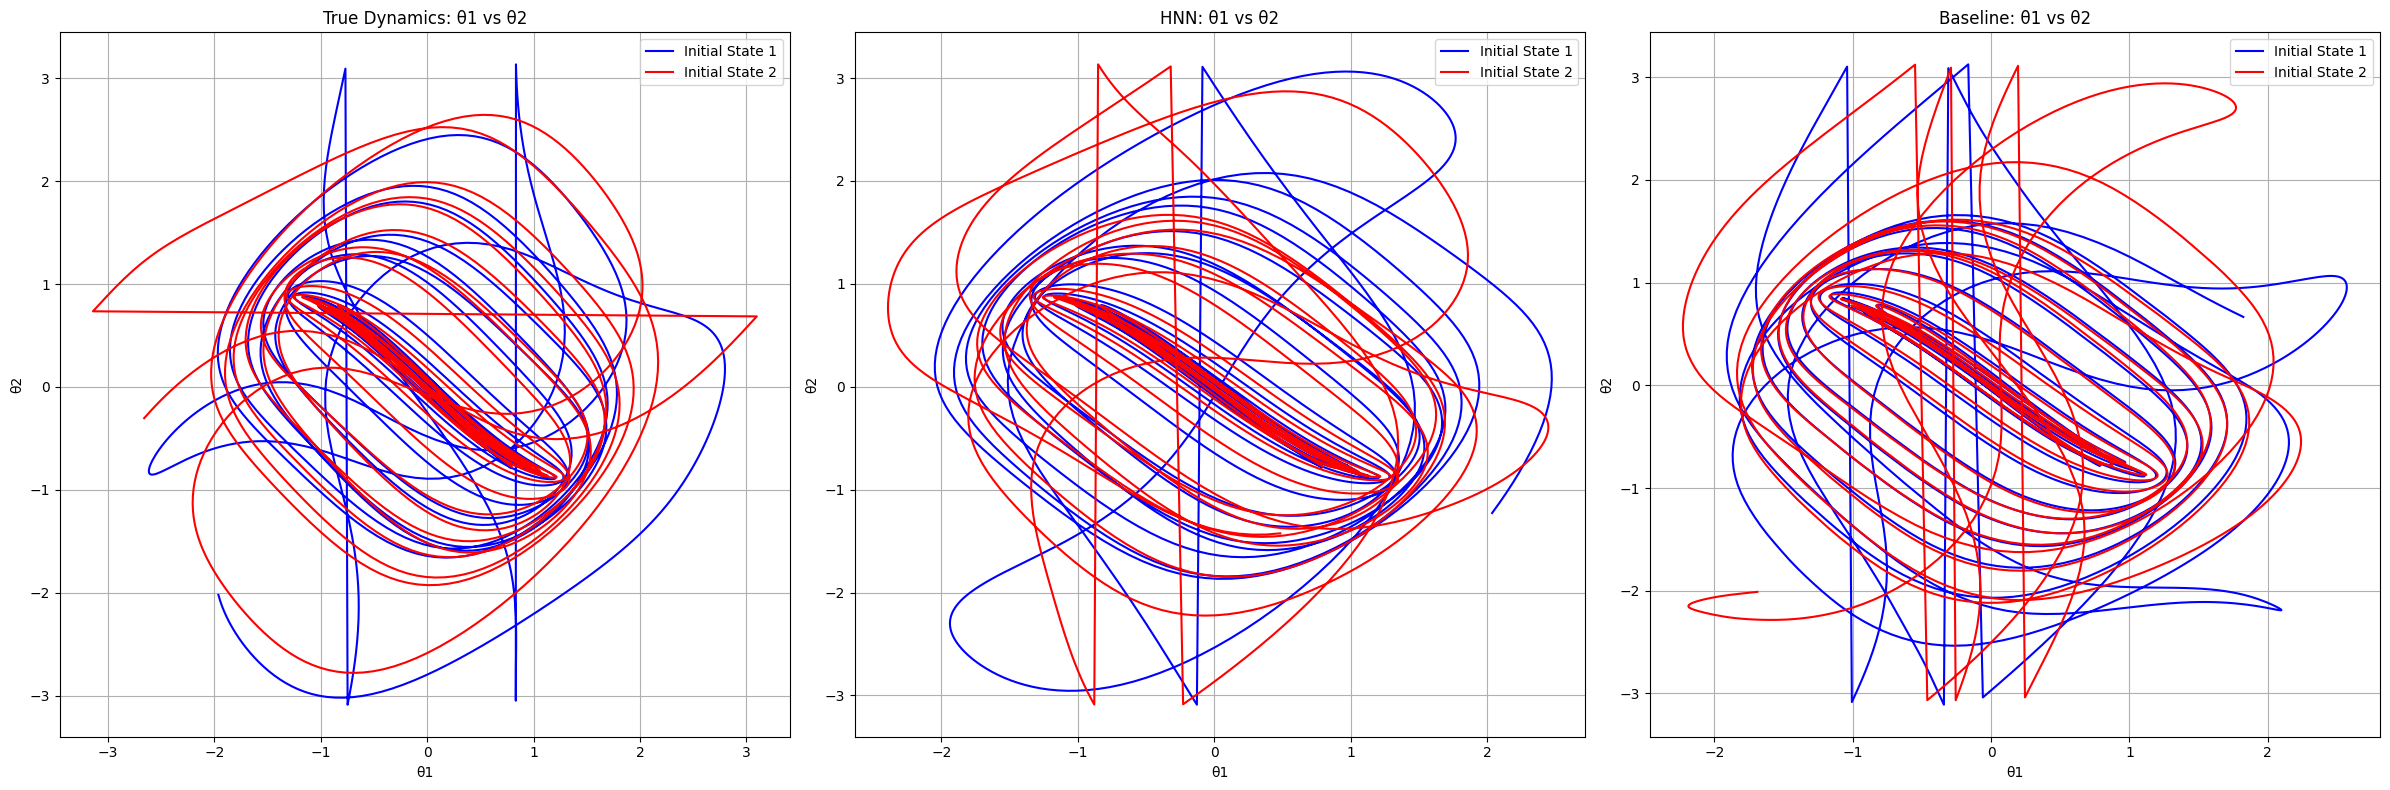

In [7]:
def stormer_verlet_step(model, state, dt, m1, m2, l1, l2, g):
    theta1, theta2, p1, p2 = state
    
    if isinstance(model, nn.Module):
        with torch.no_grad():
            dstate = model(state.unsqueeze(0)).squeeze(0)
            dtheta1_dt, dtheta2_dt, dp1_dt, dp2_dt = dstate
    else:
        # True dynamics
        cos_diff = torch.cos(theta1 - theta2)
        sin_diff = torch.sin(theta1 - theta2)
        dtheta1_dt = (l2 * p1 - l1 * p2 * cos_diff) / (l1**2 * l2 * (m1 + m2 * sin_diff**2))
        dtheta2_dt = (-m2 * l2 * p1 * cos_diff + (m1 + m2) * l1 * p2) / (m2 * l1 * l2**2 * (m1 + m2 * sin_diff**2))
        h1 = p1*p2*sin_diff / (l1*l2*(m1 + m2*sin_diff**2))
        h2 = (m2*l2**2*p1**2 + (m1 + m2)*l1**2*p2**2 - 2*m2*l1*l2*p1*p2*cos_diff) / (2*l1**2*l2**2*(m1 + m2*sin_diff**2)**2)
        dp1_dt = -(m1 + m2) * g * l1 * torch.sin(theta1) - h1 + h2*torch.sin(2*(theta1 - theta2))
        dp2_dt = -m2 * g * l2 * torch.sin(theta2) + h1 - h2*torch.sin(2*(theta1 - theta2))
    
    # Half step in momenta
    p1_half = p1 + 0.5 * dt * dp1_dt
    p2_half = p2 + 0.5 * dt * dp2_dt
    
    # Full step in positions
    theta1_new = theta1 + dt * dtheta1_dt
    theta2_new = theta2 + dt * dtheta2_dt
    
    # Recompute derivatives at new positions
    state_new = torch.stack([theta1_new, theta2_new, p1_half, p2_half])
    if isinstance(model, nn.Module):
        with torch.no_grad():
            dstate_new = model(state_new.unsqueeze(0)).squeeze(0)
            _, _, dp1_dt_new, dp2_dt_new = dstate_new
    else:
        # Recompute true dynamics at new state
        cos_diff = torch.cos(theta1_new - theta2_new)
        sin_diff = torch.sin(theta1_new - theta2_new)
        h1 = p1_half*p2_half*sin_diff / (l1*l2*(m1 + m2*sin_diff**2))
        h2 = (m2*l2**2*p1_half**2 + (m1 + m2)*l1**2*p2_half**2 - 2*m2*l1*l2*p1_half*p2_half*cos_diff) / (2*l1**2*l2**2*(m1 + m2*sin_diff**2)**2)
        dp1_dt_new = -(m1 + m2) * g * l1 * torch.sin(theta1_new) - h1 + h2*torch.sin(2*(theta1_new - theta2_new))
        dp2_dt_new = -m2 * g * l2 * torch.sin(theta2_new) + h1 - h2*torch.sin(2*(theta1_new - theta2_new))
    
    # Complete step in momenta
    p1_new = p1_half + 0.5 * dt * dp1_dt_new
    p2_new = p2_half + 0.5 * dt * dp2_dt_new
    
    # make sure that theta1, and theta2 are between -pi, and pi
    theta1_new = (theta1_new + np.pi) % (2 * np.pi) - np.pi
    theta2_new = (theta2_new + np.pi) % (2 * np.pi) - np.pi

    return torch.stack([theta1_new, theta2_new, p1_new, p2_new])

def simulate_trajectory(model, initial_state, steps, dt, m1, m2, l1, l2, g):
    trajectory = [initial_state]
    state = initial_state.clone()

    for _ in range(steps - 1):
        state = stormer_verlet_step(model, state, dt, m1, m2, l1, l2, g)
        trajectory.append(state)

    return torch.stack(trajectory)

# Simulation parameters
initial_state1 = torch.tensor([np.pi/4, -np.pi/4, 0.0, 0.0], dtype=torch.float32)
initial_state2 = initial_state1 + torch.tensor([0.01, 0.01, 0.0, 0.0], dtype=torch.float32)
steps = 2000
dt = config['dt']
m1, m2, l1, l2, g = config['mass1'], config['mass2'], config['length1'], config['length2'], config['g']

# Simulate trajectories
hnn_traj1 = simulate_trajectory(hnn_model, initial_state1, steps, dt, m1, m2, l1, l2, g)
hnn_traj2 = simulate_trajectory(hnn_model, initial_state2, steps, dt, m1, m2, l1, l2, g)
baseline_traj1 = simulate_trajectory(baseline_model, initial_state1, steps, dt, m1, m2, l1, l2, g)
baseline_traj2 = simulate_trajectory(baseline_model, initial_state2, steps, dt, m1, m2, l1, l2, g)
true_traj1 = simulate_trajectory(None, initial_state1, steps, dt, m1, m2, l1, l2, g)
true_traj2 = simulate_trajectory(None, initial_state2, steps, dt, m1, m2, l1, l2, g)

# Plot trajectories
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 8))

ax1.plot(true_traj1[:, 0], true_traj1[:, 1], label='Initial State 1', color='blue')
ax1.plot(true_traj2[:, 0], true_traj2[:, 1], label='Initial State 2', color='red')
ax1.set_title('True Dynamics: θ1 vs θ2')
ax1.set_xlabel('θ1')
ax1.set_ylabel('θ2')
ax1.legend()
ax1.grid(True)

ax2.plot(hnn_traj1[:, 0], hnn_traj1[:, 1], label='Initial State 1', color='blue')
ax2.plot(hnn_traj2[:, 0], hnn_traj2[:, 1], label='Initial State 2', color='red')
ax2.set_title('HNN: θ1 vs θ2')
ax2.set_xlabel('θ1')
ax2.set_ylabel('θ2')
ax2.legend()
ax2.grid(True)

ax3.plot(baseline_traj1[:, 0], baseline_traj1[:, 1], label='Initial State 1', color='blue')
ax3.plot(baseline_traj2[:, 0], baseline_traj2[:, 1], label='Initial State 2', color='red')
ax3.set_title('Baseline: θ1 vs θ2')
ax3.set_xlabel('θ1')
ax3.set_ylabel('θ2')
ax3.legend()
ax3.grid(True)

plt.tight_layout()
plt.show()

The plots above shows that there is chaotic behavior in all cases (expected result), but the hnn model is more coherent than the MLP one.

That means that the RMSE evaluated on a single forward step is not a good metric: during training we try to minimize this metric, but MLP is not consistent in time (a RNN should do a better job), instead HNN dynamics is similar to the ground truth, even with this simple training setup.

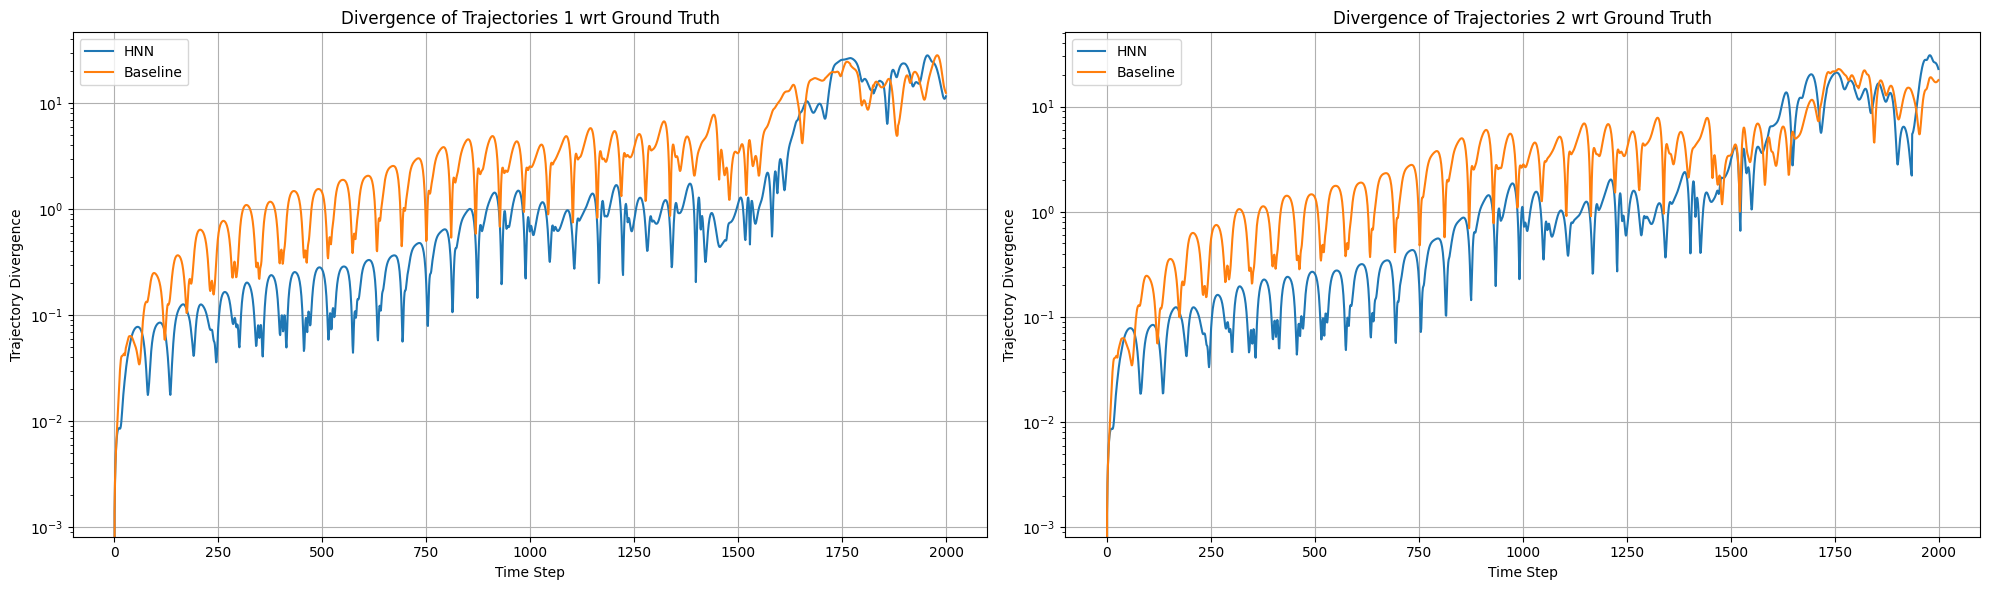

In [8]:
def compute_trajectory_divergence(traj1: torch.Tensor, traj2: torch.Tensor) -> np.ndarray:
    return torch.norm(traj1 - traj2, dim=1).numpy()

# Compute divergences for traj1
hnn_divergence1 = compute_trajectory_divergence(hnn_traj1, true_traj1)
baseline_divergence1 = compute_trajectory_divergence(baseline_traj1, true_traj1)

# Compute divergences for traj2
hnn_divergence2 = compute_trajectory_divergence(hnn_traj2, true_traj2)
baseline_divergence2 = compute_trajectory_divergence(baseline_traj2, true_traj2)

# Create two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# Plot for traj1
ax1.plot(hnn_divergence1, label='HNN')
ax1.plot(baseline_divergence1, label='Baseline')
ax1.set_xlabel('Time Step')
ax1.set_ylabel('Trajectory Divergence')
ax1.set_title('Divergence of Trajectories 1 wrt Ground Truth')
ax1.legend()
ax1.set_yscale('log')
ax1.grid(True)

# Plot for traj2
ax2.plot(hnn_divergence2, label='HNN')
ax2.plot(baseline_divergence2, label='Baseline')
ax2.set_xlabel('Time Step')
ax2.set_ylabel('Trajectory Divergence')
ax2.set_title('Divergence of Trajectories 2 wrt Ground Truth')
ax2.legend()
ax2.set_yscale('log')
ax2.grid(True)

plt.tight_layout()
plt.show()

Now, I extend a little bit the experiment done before, in order to understand if there is a trend among different time series, so I generate 100 trajectories of length 1200, and I compute the mean and std divergence. (if you want to run this cell go to take a coffee because it takes 10 minutes approx)

In [9]:
import tqdm

def generate_random_initial_state():
    return torch.tensor([
        np.random.uniform(-np.pi, np.pi),
        np.random.uniform(-np.pi, np.pi),
        np.random.uniform(-10, 10),
        np.random.uniform(-10, 10)
    ], dtype=torch.float32)

def generate_multiple_trajectories(model, initial_states, steps, dt, m1, m2, l1, l2, g):
    trajectories = []
    for initial_state in tqdm.tqdm(initial_states, desc=f"Generating trajectories for {'True' if model is None else 'HNN' if isinstance(model, HNN) else 'Baseline'}"):
        trajectory = simulate_trajectory(model, initial_state, steps, dt, m1, m2, l1, l2, g)
        trajectories.append(trajectory)
    return torch.stack(trajectories)

def compute_geometric_statistics(true_trajectories, model_trajectories):
    divergences = torch.norm(true_trajectories - model_trajectories, dim=2)
    
    # Compute geometric mean
    log_divergences = torch.log(divergences + 1e-10)  # Add small epsilon to avoid log(0)
    geo_mean = torch.exp(torch.mean(log_divergences, dim=0))
    
    # Compute geometric standard deviation
    geo_std = torch.exp(torch.std(log_divergences, dim=0))
    
    return geo_mean.numpy(), geo_std.numpy()

# Simulation parameters
num_trajectories = 100
steps = 1200
dt = config['dt']
m1, m2, l1, l2, g = config['mass1'], config['mass2'], config['length1'], config['length2'], config['g']

# Generate a set of initial states to be used for all models
initial_states = [generate_random_initial_state() for _ in range(num_trajectories)]

# Generate trajectories using the same initial states for all models
true_trajectories = generate_multiple_trajectories(None, initial_states, steps, dt, m1, m2, l1, l2, g)
hnn_trajectories = generate_multiple_trajectories(hnn_model, initial_states, steps, dt, m1, m2, l1, l2, g)
baseline_trajectories = generate_multiple_trajectories(baseline_model, initial_states, steps, dt, m1, m2, l1, l2, g)

Generating trajectories for HNN: 100%|██████████| 100/100 [00:42<00:00,  2.38it/s]


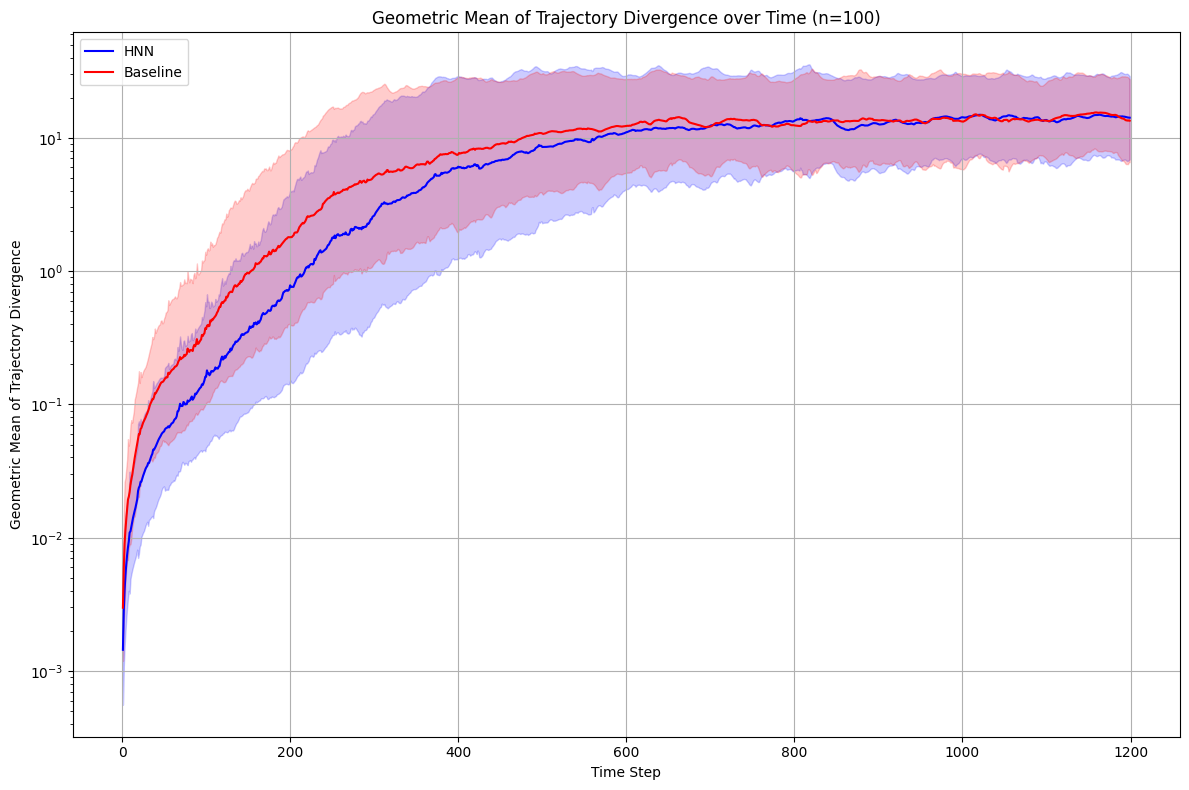

In [10]:
# Compute geometric mean and standard deviation
hnn_geo_mean, hnn_geo_std = compute_geometric_statistics(true_trajectories, hnn_trajectories)
baseline_geo_mean, baseline_geo_std = compute_geometric_statistics(true_trajectories, baseline_trajectories)

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))

time_steps = np.arange(1, steps)
hnn_geo_mean, baseline_geo_mean = hnn_geo_mean[1:], baseline_geo_mean[1:]
hnn_geo_std, baseline_geo_std = hnn_geo_std[1:], baseline_geo_std[1:]

ax.plot(time_steps, hnn_geo_mean, label='HNN', color='blue')
ax.fill_between(time_steps, hnn_geo_mean / hnn_geo_std, hnn_geo_mean * hnn_geo_std, alpha=0.2, color='blue')

ax.plot(time_steps, baseline_geo_mean, label='Baseline', color='red')
ax.fill_between(time_steps, baseline_geo_mean / baseline_geo_std, baseline_geo_mean * baseline_geo_std, alpha=0.2, color='red')

ax.set_xlabel('Time Step')
ax.set_ylabel('Geometric Mean of Trajectory Divergence')
ax.set_title(f'Geometric Mean of Trajectory Divergence over Time (n={num_trajectories})')
ax.legend()
ax.set_yscale('log')
ax.grid(True)

plt.tight_layout()
plt.show()

## 8. Conclusion and Discussion

Based on our analysis of the double pendulum system, we can draw the following conclusions:

1. **RMSE Comparison**: 
   The HNN, and baseline model generally shows similar RMSE values on 1 step iteration, but HNN is stabler for longer trajectories, indicating better prediction accuracy.

2. **Chaotic Behavior**: 
   Both models capture the chaotic nature of the double pendulum system. The HNN model appears to more closely match the true system's behavior in this regard.

3. **Physical Consistency**: 
   By design, the HNN model is more likely to respect the underlying physical laws of the system, which contributes to its improved performance and stability.

In summary, the Hamiltonian Neural Network demonstrates clear advantages over the baseline model in modeling the double pendulum system. It shows better accuracy, improved capture of chaotic behavior, and enhanced long-term stability. These benefits make HNNs particularly suitable for modeling complex physical systems where preserving the underlying physical structure is crucial.

Future work could explore:
- The performance of these models on even more complex systems (e.g., triple pendulum, n-body problems)
- A deeper analysis with mathematical tools (Lyapunov spectrum, and Poincaré section)
- The impact of different training dataset sizes and distributions on the models' ability to capture chaotic behavior
- Optimization techniques to reduce the computational overhead of HNNs while maintaining their advantages
- The use of HNNs in predicting bifurcations or transitions in chaotic systems

This analysis showcases the potential of physics-informed neural networks, particularly HNNs, in improving the accuracy, stability, and physical consistency of simulations for complex, chaotic systems in various scientific and engineering domains.